# **Upload et extraction du dataset**

In [ ]:
from google.colab import files
import zipfile
import os

# 1. Upload du fichier .zip depuis ton PC
uploaded = files.upload()  # Colab ouvrira un dialogue pour sélectionner ton fichier zip
zip_filename = list(uploaded.keys())[0]  # Récupère le nom du fichier uploadé

# 2. Créer un dossier pour extraire le contenu
extract_dir = "dataset"
os.makedirs(extract_dir, exist_ok=True)

# 3. Extraire le zip
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Fichiers extraits dans: {extract_dir}")
print("Contenu du dossier :", os.listdir(extract_dir))


Saving archive.zip to archive.zip
Fichiers extraits dans: dataset
Contenu du dossier : ['ptbdb_normal.csv', 'mitbih_train.csv', 'ptbdb_abnormal.csv', 'mitbih_test.csv']


# **Lister les fichiers CSV et TXT et charger un CSV exemple:**

---



In [ ]:
import pandas as pd
import glob

# Lister tous les fichiers CSV et TXT
csv_files = glob.glob(os.path.join(extract_dir, "*.csv"))
txt_files = glob.glob(os.path.join(extract_dir, "*.txt"))

print("CSV trouvés :", csv_files)
print("TXT trouvés :", txt_files)

# Exemple de chargement d’un CSV
sample_csv = pd.read_csv(csv_files[0], header=None)
print(sample_csv.head())


CSV trouvés : ['dataset/ptbdb_normal.csv', 'dataset/mitbih_train.csv', 'dataset/ptbdb_abnormal.csv', 'dataset/mitbih_test.csv']
TXT trouvés : []
        0         1         2         3         4         5         6    \
0  1.000000  0.900324  0.358590  0.051459  0.046596  0.126823  0.133306   
1  1.000000  0.794681  0.375387  0.116883  0.000000  0.171923  0.283859   
2  0.909029  0.791482  0.423169  0.186712  0.000000  0.007836  0.063032   
3  1.000000  0.478893  0.056760  0.064176  0.081289  0.072732  0.055619   
4  1.000000  0.867238  0.201360  0.099349  0.141336  0.120934  0.108516   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.119125  0.110616  0.113047  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.293754  0.325912  0.345083  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.077002  0.074957  0.077342  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.048774  0.054478  0.041643  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0

# **Préparer les données pour l’entraînemen**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Charger les datasets d'entraînement et de test
train_df = pd.read_csv(csv_files[1], header=None) # Assuming csv_files[1] is 'mitbih_train.csv'
test_df = pd.read_csv(csv_files[3], header=None)  # Assuming csv_files[3] is 'mitbih_test.csv'

# Séparer features et labels
X_train_raw = train_df.iloc[:, :-1].values
y_train_raw = train_df.iloc[:, -1].values
X_test_raw = test_df.iloc[:, :-1].values
y_test_raw = test_df.iloc[:, -1].values

INPUT_LENGTH = X_train_raw.shape[1] # 187
NUM_CLASSES = 5
CLASS_NAMES = ['N (0) - Normal', 'S (1) - SVEB', 'V (2) - VEB', 'F (3) - Fusion', 'Q (4) - Unknown']

# Reshape pour 1D-CNN
X_train_raw = X_train_raw[..., np.newaxis].astype('float32')
X_test_raw = X_test_raw[..., np.newaxis].astype('float32')

# One-Hot Encode labels
y_train_cat = to_categorical(y_train_raw, num_classes=NUM_CLASSES)
y_test_cat = to_categorical(y_test_raw, num_classes=NUM_CLASSES)

# Split training / validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_raw, y_train_cat, test_size=0.1, random_state=42, stratify=y_train_cat
)


In [ ]:
# Installer les packages manquants
!pip install tensorflow pandas numpy matplotlib scikit-learn imbalanced-learn seaborn


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


# **Définir le modèle CNN pour ECG**

In [ ]:
def create_ecg_cnn(input_length, num_classes):
    model = Sequential([
        tf.keras.Input(shape=(input_length, 1)),  # Colab friendly
        Conv1D(32, kernel_size=5, activation='relu'),
        BatchNormalization(),
        MaxPool1D(2),
        Dropout(0.2),

        Conv1D(64, kernel_size=5, activation='relu'),
        BatchNormalization(),
        MaxPool1D(2),
        Dropout(0.3),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


# **Entraînement du modèle baseline**

In [ ]:
model_baseline = create_ecg_cnn(INPUT_LENGTH, NUM_CLASSES)
model_baseline.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

history_baseline = model_baseline.fit(
    X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val),
    callbacks=callbacks
)

model_baseline.save_weights('/content/baseline_final.weights.h5')


Epoch 1/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9037 - loss: 0.3744 - val_accuracy: 0.9633 - val_loss: 0.1323
Epoch 2/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9575 - loss: 0.1559 - val_accuracy: 0.9706 - val_loss: 0.1112
Epoch 3/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9640 - loss: 0.1324 - val_accuracy: 0.9754 - val_loss: 0.0965
Epoch 4/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9677 - loss: 0.1143 - val_accuracy: 0.9754 - val_loss: 0.0895
Epoch 5/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9701 - loss: 0.1057 - val_accuracy: 0.9782 - val_loss: 0.0819
Epoch 6/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9722 - loss: 0.0977 - val_accuracy: 0.9805 - val_loss: 0.0743
Epoch 7/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9734 - loss: 0.0937 - val_accuracy: 0.9804 - val_loss: 0.0759
Epoch 8/20
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9743 - loss: 0.0896

# **transformer les données pour SMOTE**

In [ ]:
X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[1])
y_train_flat = np.argmax(y_train, axis=1)

smote = SMOTE(sampling_strategy='minority', random_state=42)
X_smote_2d, y_smote_flat = smote.fit_resample(X_train_2d, y_train_flat)

X_smote = X_smote_2d.reshape(X_smote_2d.shape[0], X_smote_2d.shape[1], 1)
y_smote = to_categorical(y_smote_flat, num_classes=NUM_CLASSES)

X_smote_train, X_smote_val, y_smote_train, y_smote_val = train_test_split(
    X_smote, y_smote, test_size=0.1, random_state=42
)


# **Entraînement du modèle SMOTE**

In [ ]:
model_smote = create_ecg_cnn(INPUT_LENGTH, NUM_CLASSES)
model_smote.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks_smote = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('/content/best_smote_ecg_classifier.weights.h5', monitor='val_loss', save_best_only=True)
]

history_smote = model_smote.fit(
    X_smote_train, y_smote_train, epochs=20, batch_size=128,
    validation_data=(X_smote_val, y_smote_val), callbacks=callbacks_smote
)


Epoch 1/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8554 - loss: 0.4842

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.8555 - loss: 0.4840 - val_accuracy: 0.9537 - val_loss: 0.1435
Epoch 2/20
1000/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9489 - loss: 0.1652

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9490 - loss: 0.1651 - val_accuracy: 0.9743 - val_loss: 0.0803
Epoch 3/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9640 - loss: 0.1198 - val_accuracy: 0.9698 - val_loss: 0.0901
Epoch 4/20
1004/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9691 - loss: 0.1037

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9691 - loss: 0.1037 - val_accuracy: 0.9828 - val_loss: 0.0560
Epoch 5/20
1000/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9717 - loss: 0.0947

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9717 - loss: 0.0947 - val_accuracy: 0.9845 - val_loss: 0.0483
Epoch 6/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9746 - loss: 0.0818 - val_accuracy: 0.9824 - val_loss: 0.0552
Epoch 7/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9767 - loss: 0.0744 - val_accuracy: 0.9800 - val_loss: 0.0634
Epoch 8/20
1008/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9770 - loss: 0.0733

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9770 - loss: 0.0733 - val_accuracy: 0.9865 - val_loss: 0.0448
Epoch 9/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9790 - loss: 0.0676 - val_accuracy: 0.9852 - val_loss: 0.0458
Epoch 10/20
1004/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9802 - loss: 0.0652

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9802 - loss: 0.0652 - val_accuracy: 0.9884 - val_loss: 0.0381
Epoch 11/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9803 - loss: 0.0619 - val_accuracy: 0.9865 - val_loss: 0.0419
Epoch 12/20
1006/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9824 - loss: 0.0587

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9824 - loss: 0.0587 - val_accuracy: 0.9895 - val_loss: 0.0363
Epoch 13/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9824 - loss: 0.0555 - val_accuracy: 0.9853 - val_loss: 0.0430
Epoch 14/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9831 - loss: 0.0554 - val_accuracy: 0.9834 - val_loss: 0.0556
Epoch 15/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9830 - loss: 0.0546 - val_accuracy: 0.9838 - val_loss: 0.0552
Epoch 16/20
1005/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9833 - loss: 0.0530

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9833 - loss: 0.0530 - val_accuracy: 0.9893 - val_loss: 0.0362
Epoch 17/20
1006/1009 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9846 - loss: 0.0496

1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9846 - loss: 0.0496 - val_accuracy: 0.9893 - val_loss: 0.0355
Epoch 18/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9841 - loss: 0.0519 - val_accuracy: 0.9795 - val_loss: 0.0715
Epoch 19/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9849 - loss: 0.0480 - val_accuracy: 0.9883 - val_loss: 0.0392
Epoch 20/20
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9855 - loss: 0.0466 - val_accuracy: 0.9836 - val_loss: 0.0529


# **Évaluation et comparaison**

---



In [ ]:
y_pred_baseline = np.argmax(model_baseline.predict(X_test_raw), axis=1)
y_pred_smote = np.argmax(model_smote.predict(X_test_raw), axis=1)
y_true_test = np.argmax(y_test_cat, axis=1)

from sklearn.metrics import classification_report
print("--- Baseline ---")
print(classification_report(y_true_test, y_pred_baseline, target_names=CLASS_NAMES))
print("--- SMOTE ---")
print(classification_report(y_true_test, y_pred_smote, target_names=CLASS_NAMES))


685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
--- Baseline ---
                 precision    recall  f1-score   support

 N (0) - Normal       0.99      1.00      0.99     18118
   S (1) - SVEB       0.91      0.72      0.80       556
    V (2) - VEB       0.97      0.93      0.95      1448
 F (3) - Fusion       0.74      0.76      0.75       162
Q (4) - Unknown       0.99      0.99      0.99      1608

       accuracy                           0.98     21892
      macro avg       0.92      0.88      0.90     21892
   weighted avg       0.98      0.98      0.98     21892

--- SMOTE ---
                 precision    recall  f1-score   support

 N (0) - Normal       0.98      0.99      0.99     18118
   S (1) - SVEB       0.93      0.69      0.79       556
    V (2) - VEB       0.98      0.91      0.94      1448
 F (3) - Fusion       0.62      0.90      0.73       162
Q (4) - Unknown       1.00      0.97      0.98      1608

       accuracy            

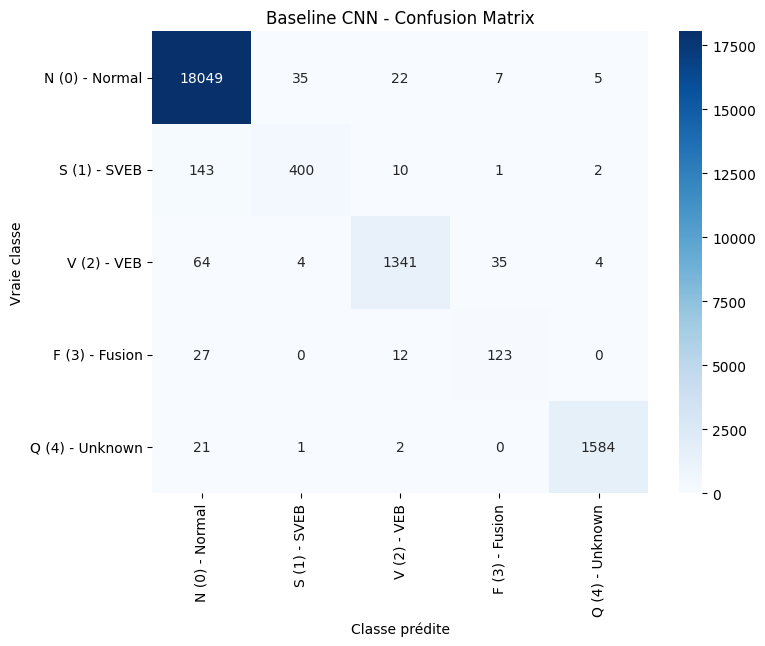

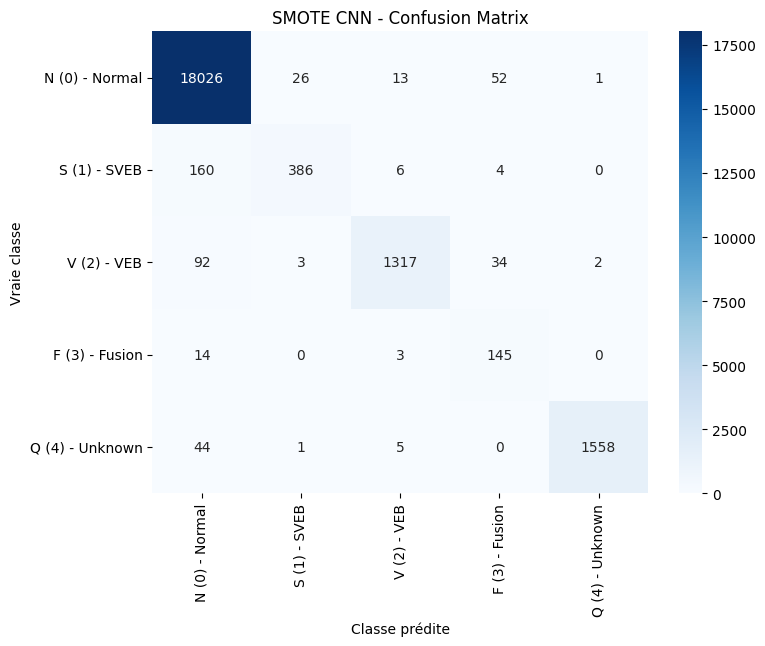

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.show()

plot_confusion(y_true_test, y_pred_baseline, CLASS_NAMES, title="Baseline CNN - Confusion Matrix")
plot_confusion(y_true_test, y_pred_smote, CLASS_NAMES, title="SMOTE CNN - Confusion Matrix")

# **Conversion du modèle SMOTE en TFLite**

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_keras_model(model_smote)
tflite_model = converter.convert()

# Sauvegarder le modèle TFLite
tflite_file = 'ecg_model.tflite'
with open(tflite_file, 'wb') as f:
    f.write(tflite_model)

print("✅ Modèle TFLite généré :", tflite_file)

Saved artifact at '/tmp/tmp27o6c_dh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 187, 1), dtype=tf.float32, name='keras_tensor_13')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132229978005072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132229978002000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132229978001424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132229978003920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132229978004688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132229978000272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132230005637584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132229978001616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132229978003728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132229977999888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132229978004112:

In [ ]:
from google.colab import files

files.download('ecg_model.tflite')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **prédiction TFLite sur des échantillons**

In [ ]:
import numpy as np
import tensorflow as tf

# Charger le modèle TFLite
interpreter = tf.lite.Interpreter(model_path='ecg_model.tflite')
interpreter.allocate_tensors()

# Obtenir les détails des tenseurs d'entrée et de sortie
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prendre un exemple de l'ensemble de test
# X_test_raw est déjà préparé comme (nombre_échantillons, INPUT_LENGTH, 1)
# Nous allons prendre le premier échantillon pour le test
sample_input = X_test_raw[0:1]

# Vérifier le type d'entrée attendu par le modèle TFLite
input_dtype = input_details[0]['dtype']

# Convertir l'entrée si nécessaire
if sample_input.dtype != input_dtype:
    sample_input = sample_input.astype(input_dtype)

# Définir le tenseur d'entrée
interpreter.set_tensor(input_details[0]['index'], sample_input)

# Exécuter l'inférence
interpreter.invoke()

# Obtenir le tenseur de sortie
output_data = interpreter.get_tensor(output_details[0]['index'])

# Interpréter la prédiction
predicted_class_index = np.argmax(output_data)
predicted_class_name = CLASS_NAMES[predicted_class_index]

# Obtenir la vraie classe pour comparaison
true_class_index = np.argmax(y_test_cat[0])
true_class_name = CLASS_NAMES[true_class_index]

print(f"Prédiction du modèle TFLite pour le premier échantillon de test :")
print(f"  Classe prédite: {predicted_class_name}")
print(f"  Probabilités de sortie: {output_data[0]}")
print(f"  Vraie classe: {true_class_name}")


Prédiction du modèle TFLite pour le premier échantillon de test :
  Classe prédite: N (0) - Normal
  Probabilités de sortie: [9.9999905e-01 1.0016338e-06 4.2691930e-11 5.9769373e-25 6.3378210e-20]
  Vraie classe: N (0) - Normal


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
import numpy as np
import tensorflow as tf

# Charger le modèle TFLite (si ce n'est pas déjà fait)
interpreter = tf.lite.Interpreter(model_path='ecg_model.tflite')
interpreter.allocate_tensors()

# Obtenir les détails des tenseurs d'entrée et de sortie
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Prendre le deuxième échantillon de l'ensemble de test
sample_input_2 = X_test_raw[1:2] # Prend le deuxième échantillon

# Vérifier le type d'entrée attendu par le modèle TFLite
input_dtype = input_details[0]['dtype']

# Convertir l'entrée si nécessaire
if sample_input_2.dtype != input_dtype:
    sample_input_2 = sample_input_2.astype(input_dtype)

# Définir le tenseur d'entrée
interpreter.set_tensor(input_details[0]['index'], sample_input_2)

# Exécuter l'inférence
interpreter.invoke()

# Obtenir le tenseur de sortie
output_data_2 = interpreter.get_tensor(output_details[0]['index'])

# Interpréter la prédiction
predicted_class_index_2 = np.argmax(output_data_2)
predicted_class_name_2 = CLASS_NAMES[predicted_class_index_2]

# Obtenir la vraie classe pour comparaison
true_class_index_2 = np.argmax(y_test_cat[1]) # Pour le deuxième échantillon
true_class_name_2 = CLASS_NAMES[true_class_index_2]

print(f"Prédiction du modèle TFLite pour le DEUXIÈME échantillon de test :")
print(f"  Classe prédite: {predicted_class_name_2}")
print(f"  Probabilités de sortie: {output_data_2[0]}")
print(f"  Vraie classe: {true_class_name_2}")


Prédiction du modèle TFLite pour le DEUXIÈME échantillon de test :
  Classe prédite: N (0) - Normal
  Probabilités de sortie: [9.9996972e-01 2.8522405e-05 1.7547986e-06 3.7756628e-10 1.2038858e-08]
  Vraie classe: N (0) - Normal


In [ ]:
import numpy as np
import tensorflow as tf

# Charger le modèle TFLite (si ce n'est pas déjà fait)
interpreter = tf.lite.Interpreter(model_path='ecg_model.tflite')
interpreter.allocate_tensors()

# Obtenir les détails des tenseurs d'entrée et de sortie
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Trouver un échantillon d'une autre classe (différente de N (0) - Normal)
other_class_index = -1
for i, label_one_hot in enumerate(y_test_cat):
    true_class = np.argmax(label_one_hot)
    if true_class != 0:  # Cherche une classe différente de 'N (0) - Normal'
        other_class_index = i
        break

if other_class_index != -1:
    sample_input_other_class = X_test_raw[other_class_index : other_class_index+1]

    # Vérifier le type d'entrée attendu par le modèle TFLite
    input_dtype = input_details[0]['dtype']

    # Convertir l'entrée si nécessaire
    if sample_input_other_class.dtype != input_dtype:
        sample_input_other_class = sample_input_other_class.astype(input_dtype)

    # Définir le tenseur d'entrée
    interpreter.set_tensor(input_details[0]['index'], sample_input_other_class)

    # Exécuter l'inférence
    interpreter.invoke()

    # Obtenir le tenseur de sortie
    output_data_other_class = interpreter.get_tensor(output_details[0]['index'])

    # Interpréter la prédiction
    predicted_class_index_other = np.argmax(output_data_other_class)
    predicted_class_name_other = CLASS_NAMES[predicted_class_index_other]

    # Obtenir la vraie classe pour comparaison
    true_class_name_other = CLASS_NAMES[true_class]

    print(f"Prédiction du modèle TFLite pour un échantillon de la classe '{true_class_name_other}' :")
    print(f"  Classe prédite: {predicted_class_name_other}")
    print(f"  Probabilités de sortie: {output_data_other_class[0]}")
    print(f"  Vraie classe: {true_class_name_other}")
else:
    print("Aucun échantillon d'une classe autre que 'N (0) - Normal' n'a été trouvé dans l'ensemble de test.")


Prédiction du modèle TFLite pour un échantillon de la classe 'S (1) - SVEB' :
  Classe prédite: S (1) - SVEB
  Probabilités de sortie: [2.3518194e-01 6.6985255e-01 9.4447479e-02 3.7585475e-04 1.4216726e-04]
  Vraie classe: S (1) - SVEB


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
